In [ ]:
# Alex Khan

In [69]:
from braket.aws import AwsDevice
from braket.devices import LocalSimulator
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
'Delete this block in final version'

# Enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-qc-packt-book-ak-2022" # the name of the bucket
my_prefix = "ionq" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [3]:
rng = np.random

In [4]:
device_list=AwsDevice.get_devices(statuses=['ONLINE'])
for i in device_list:
    print(i)

Device('name': Advantage_system1.1, 'arn': arn:aws:braket:::device/qpu/d-wave/Advantage_system1)
Device('name': Aspen-9, 'arn': arn:aws:braket:::device/qpu/rigetti/Aspen-9)
Device('name': DW_2000Q_6, 'arn': arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6)
Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)
Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
Device('name': dm1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/dm1)


In [5]:
device_ionq = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
device_local = LocalSimulator()

In [6]:
# Gates for LocalSimulator
supported_gates = device_local.properties.action['braket.ir.jaqcd.program'].supportedOperations
print(supported_gates)

['CCNot', 'CNot', 'CPhaseShift', 'CPhaseShift00', 'CPhaseShift01', 'CPhaseShift10', 'CSwap', 'CY', 'CZ', 'H', 'I', 'ISwap', 'PSwap', 'PhaseShift', 'Rx', 'Ry', 'Rz', 'S', 'Si', 'Swap', 'T', 'Ti', 'Unitary', 'V', 'Vi', 'X', 'XX', 'XY', 'Y', 'YY', 'Z', 'ZZ']


In [7]:
# Gates for IonQ
supported_gates = device_ionq.properties.action['braket.ir.jaqcd.program'].supportedOperations
print(supported_gates)

['x', 'y', 'z', 'rx', 'ry', 'rz', 'h', 'cnot', 's', 'si', 't', 'ti', 'v', 'vi', 'xx', 'yy', 'zz', 'swap', 'i']


In [8]:
price_per_shot=device_ionq.properties.service.deviceCost.price
unit=device_ionq.properties.service.deviceCost.unit
num_shots=10
cost_per_task=0.3
print('device cost per ',unit,': $', price_per_shot)
print('total cost for {} shots is ${:.2f}'.format(num_shots,cost_per_task+num_shots*price_per_shot))

device cost per  shot : $ 0.01
total cost for 10 shots is $0.40


read about Amazon Braket
https://docs.aws.amazon.com/braket/latest/developerguide/braket-developer-guide.pdf

    
read about ionQ
https://ionq.com/best-practices/
    

$\begin{align}\begin{aligned}\newcommand{\th}{\frac{\theta}{2}}\\\begin{split}U3(\theta, \phi, \lambda) =
    \begin{pmatrix}
        \cos(\th)          & -e^{i\lambda}\sin(\th) \\
        e^{i\phi}\sin(\th) & e^{i(\phi+\lambda)}\cos(\th)
    \end{pmatrix}\end{split}\end{aligned}\end{align}$

$U3(θ,ϕ,λ)=RZ(ϕ)RX(−π/2)RZ(θ)RX(π/2)RZ(λ)$

$\lambda = -\phi$

$\begin{align}\begin{aligned}\newcommand{\th}{\frac{\theta}{2}}\\\begin{split}U_r(\theta, \phi) =
    \begin{pmatrix}
        \cos(\th)          & -e^{-i\phi}\sin(\th) \\
        e^{i\phi}\sin(\th) & \cos(\th)
    \end{pmatrix}\end{split}\end{aligned}\end{align}$

$U_r(\theta, \phi) =
    RZ(\phi) RX(-\pi/2) RZ(\theta) RX(\pi/2) RZ(-\phi)$

In [22]:
# Single qubit gate  U_r(Theta, phi)  
def u_r (circ, q, Theta, phi):

    circ.rz(q, phi).rx(q, -np.pi/2).rz(q, Theta).rx(q, np.pi/2).rz(q, -phi)
    
    return(circ)

The M gate is defined as the xx gate for IonQ

$\begin{align}\begin{aligned}\newcommand{\th}{\frac{\theta}{2}}\\\begin{split}R_{XX}(\theta) = exp(-i \th X{\otimes}X) =
    \begin{pmatrix}
        \cos(\th)   & 0           & 0           & -i\sin(\th) \\
        0           & \cos(\th)   & -i\sin(\th) & 0 \\
        0           & -i\sin(\th) & \cos(\th)   & 0 \\
        -i\sin(\th) & 0           & 0           & \cos(\th)
    \end{pmatrix}\end{split}\end{aligned}\end{align}$

In [23]:
# Two qubit gate
def u_m (circ, q, r, Theta ):
    
    circ.xx(q,r,rng.random()*np.pi )
    
    return(circ)
    

In [38]:
def run_circ(device, N, depth, shots, print_circ=False, s3_folder=''):
    circ=Circuit()
    alternate=False
    for i in range (depth):
        
        # Ur gate added to each qubit
        for j in range(N):
            circ=u_r(circ, j, rng.random()*2*np.pi, rng.random()*2*np.pi)
            
        # Now xx gate alternate order
        idx_first = i % 2
        
        for j in range(idx_first,N-1,2):
            circ=u_m(circ, j, j+1, rng.random()*2*np.pi)
                
    if print_circ==True:
        print(circ)
    if device.name=='StateVectorSimulator':
        result = device.run(circ, shots=shots).result()
    else:
        result = device.run(circ, s3_folder, shots=shots).result()
    
    counts = result.measurement_counts
    return(counts)

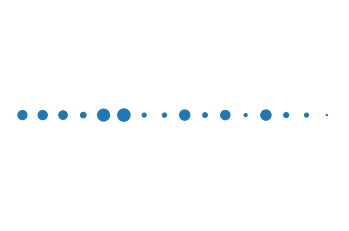

In [77]:
# run on local device, get probability distribution using one random circuit
N=4
depth=5
shots=1000
y_list=np.zeros(2**N)

counts=run_circ(device_local, N, depth, shots, False)
#print(counts)
plt.axis('off')
plt.scatter(counts.keys(), y_list, list(counts.values()))


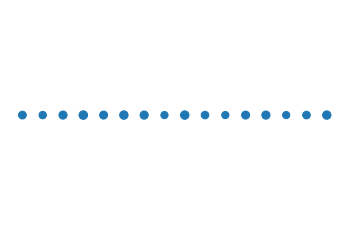

In [78]:
#run on local many times using different random circuits

shots=1

result_list=[]
for i in range(1000):
    result_list.append(run_circ(device_local, N, depth, 1))
#print(result_list) 
counts={}
for result in result_list:
    for i in result:
        #print(i)
        if i in counts:
            counts[i] += 1
        else:
            counts[i] = 1
#print(counts)
plt.axis('off')
plt.scatter(counts.keys(), y_list, list(counts.values()))


In [ ]:
'STOP here if you do not want to pay for IonQ cost'

In [ ]:
# Now run on IonQ

Counter({'1101': 11, '0010': 10, '0001': 9, '1100': 8, '0000': 7, '1110': 7, '0101': 7, '0110': 6, '1001': 6, '0011': 6, '0111': 6, '1111': 5, '1010': 4, '1011': 4, '0100': 3, '1000': 1})


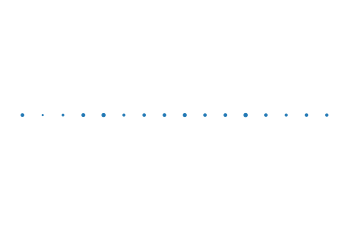

In [80]:
# run on ionQ device, get probability distribution using one random circuit
shots=100

counts=run_circ(device_ionq, N, depth, shots, False, s3_folder)
print(counts)
plt.axis('off')
plt.scatter(counts.keys(), y_list, list(counts.values()))

T  : |   0    |    1    |    2    |   3    |    4    |5|   6    |    7    |    8    |   9    |   10    |11|
                                                                                                           
q0 : -Rz(4.85)-Rx(-1.57)-Rz(0.887)-Rx(1.57)-Rz(-4.85)-C-Rz(5.13)-Rx(-1.57)-Rz(6.22)--Rx(1.57)-Rz(-5.13)-C--
                                                      |                                                 |  
q1 : -Rz(5.27)-Rx(-1.57)-Rz(0.984)-Rx(1.57)-Rz(-5.27)-X-Rz(1.51)-Rx(-1.57)-Rz(0.244)-Rx(1.57)-Rz(-1.51)-X--
                                                                                                           
q2 : -Rz(2.15)-Rx(-1.57)-Rz(0.847)-Rx(1.57)-Rz(-2.15)-C-Rz(4.85)-Rx(-1.57)-Rz(0.472)-Rx(1.57)-Rz(-4.85)-C--
                                                      |                                                 |  
q3 : -Rz(1.35)-Rx(-1.57)-Rz(1.08)--Rx(1.57)-Rz(-1.35)-X-Rz(5.04)-Rx(-1.57)-Rz(3.79)--Rx(1.57)-Rz(-5.04)-X--

T  : |   0    |    1    |  

T  : |    0    |    1    |   2    |   3    |    4     |5|    6    |    7    |   8    |   9    |    10    |11|
                                                                                                             
q0 : -Rz(0.895)-Rx(-1.57)-Rz(2.85)-Rx(1.57)-Rz(-0.895)-C-Rz(2.64)--Rx(-1.57)-Rz(2.93)-Rx(1.57)-Rz(-2.64)--C--
                                                       |                                                  |  
q1 : -Rz(0.944)-Rx(-1.57)-Rz(2.28)-Rx(1.57)-Rz(-0.944)-X-Rz(0.321)-Rx(-1.57)-Rz(4.12)-Rx(1.57)-Rz(-0.321)-X--
                                                                                                             
q2 : -Rz(1.06)--Rx(-1.57)-Rz(5.16)-Rx(1.57)-Rz(-1.06)--C-Rz(1.59)--Rx(-1.57)-Rz(1.67)-Rx(1.57)-Rz(-1.59)--C--
                                                       |                                                  |  
q3 : -Rz(0.377)-Rx(-1.57)-Rz(5.05)-Rx(1.57)-Rz(-0.377)-X-Rz(1.41)--Rx(-1.57)-Rz(3.39)-Rx(1.57)-Rz(-1.41)--X--

T  : |   

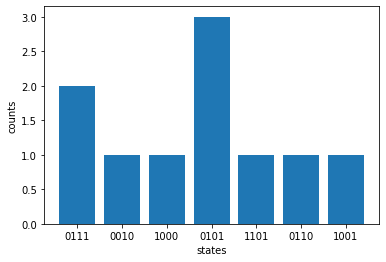

In [90]:
#run on ionQ many times using different random circuits

result_list=[]
for i in range(10):
    result_list.append(run_circ(device_ionq, 4, 2, 1, True, s3_folder))
#print(result_list) 
counts={}
for result in result_list:
    for i in result:
        #print(i)
        if i in counts:
            counts[i] += 1
        else:
            counts[i] = 1
#print(counts)
plt.bar(counts.keys(), counts.values());
plt.xlabel('states');
plt.ylabel('counts');

In [ ]:
# "R"
#    [
#        cos(theta/2)    (-im * exp(-im * phi) * sin(theta/2))
#        (-im * exp(im * phi) * sin(theta/2))     cos(theta/2)
#    ]

# "M"
#    [
#        cos(Theta)    0    0    (-im * sin(Theta))
#        0    cos(Theta)    (-im * sin(Theta))    0
#        0    (-im * sin(Theta))    cos(Theta)    0
#        (-im * sin(Theta))    0    0    cos(Theta)
#    ]